In [1]:
print('Ali Nikkhah')
print('99102445')

Ali Nikkhah
99102445


# Deformable convolutions theory and implimentation

in this notebook we looked at theory of deformable convolutions and implemented a code to train model using deformable convolutions to demonstrate it's effictiveness and captured results in the end

## Some Theoratical Questions:


---
**1. Difference between Standard Convolutional Networks and Deformable Convolutional Networks in Terms of Grid Sampling:**

Explanation:
In standard Convolutional Neural Networks (CNNs), grid sampling involves the use of a fixed regular grid during the convolution operation. This fixed grid dictates how the filters slide uniformly over the input feature map. Conversely, Deformable Convolutional Networks (DCNs) introduce a different approach to grid sampling. Instead of relying on a fixed regular grid, DCNs employ deformable convolutions that utilize learnable offsets. These learnable offsets enable the network to dynamically adjust the sampling locations within the receptive field. By adapting these sampling locations based on learned offsets, DCNs can better capture object deformations, variations in shapes, and diverse spatial configurations compared to standard CNNs.

**2. How Deformable Networks Enable Flexibility in Geometric Transformations in Images:**

Explanation:
Deformable Convolutional Networks (DCNs) achieve flexibility in handling geometric transformations in images by employing deformable convolutions. Unlike traditional convolutional layers, DCNs utilize learnable offsets associated with each sampling point in the receptive field. These learnable offsets allow the network to adaptively adjust the sampling locations based on the input features. By dynamically modifying the sampling locations, DCNs can effectively capture intricate spatial transformations such as object deformations, rotations, and other geometric variations present in the images. This adaptability in sampling enables DCNs to better represent and understand geometrically transformed objects in images.

3. Why Standard Convolutional Networks Encounter Significant Challenges with Images Exhibiting Considerable Spatial Changes or Rotations in Object Geometry:

Explanation:
Standard Convolutional Neural Networks (CNNs) face notable challenges when confronted with images containing objects that undergo substantial spatial changes or rotations. This difficulty arises due to the fixed nature of the grid sampling mechanism employed by standard CNNs. In scenarios with significant spatial changes or rotations in object geometry, the fixed regular grid used by traditional CNNs might not effectively capture these transformations. As a result, the network might struggle to recognize or interpret the rotated or spatially transformed objects accurately. This limitation in adaptability to geometric variations within the input hampers the performance of standard CNNs in scenarios requiring robustness to such transformations.

**4. Calculation of Offsets in Deformable Convolution:**

Explanation:
The offsets in Deformable Convolution are calculated as learnable parameters associated with each sampling point within the receptive field. These offsets are computed based on the input features and are learned during the training process of the network. Specifically, the network learns to predict these offsets that define the spatial shifts or adjustments for the sampling points within the receptive field. These learned offsets allow the network to dynamically modify the sampling locations, thereby enabling the adaptability of the Deformable Convolutional Network to capture and process geometrically transformed features effectively.

# Implementation

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.ops as ops
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CocoDetection
from torchvision import datasets
from sklearn.metrics import precision_recall_fscore_support
import gc
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import Dataset, Subset
import torch
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
! mkdir coco
! cd coco
! mkdir content
! cd content
! mkdir train val annotations

mkdir: cannot create directory 'coco': File exists
mkdir: cannot create directory 'content': File exists
mkdir: cannot create directory 'train': File exists
mkdir: cannot create directory 'val': File exists
mkdir: cannot create directory 'annotations': File exists


In [ ]:
!pip install pycocotools
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip


In [17]:
base_path = "/kaggle/input/coco-2017-dataset/coco2017"
train_path = f"{base_path}/train2017"
train_ann = f"{base_path}/annotations/instances_train2017.json"
val_path = f"{base_path}/val2017"
val_ann = f"{base_path}/annotations/instances_val2017.json"

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([128, 128]),
    transforms.Normalize((0.5,), (0.5,)),
])


In [15]:
class CocoDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.coco = CocoDetection(root=root, annFile=annFile, transform=transform)
        self.transform = transform
    def __getitem__(self, idx):
        img, ann = self.coco[idx]
        onehotted = torch.zeros(90)
        for itm in ann:
            category_id = itm['category_id']
            onehotted[category_id-1] = 1
        return img, onehotted
    def __len__(self):
        return len(self.coco)


In [18]:
# Create CustomCocoDataset instances for train and test sets
coco__train = CocoDataset(
    root=train_path,
    annFile=train_ann,
    transform=transform
)
coco_test = CocoDataset(
    root=val_path,
    annFile=val_ann,
    transform=transform
)
rgb = 3
num_classes = 90
train_len = 5000

loading annotations into memory...
Done (t=24.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [19]:
coco_train_dataset = Subset(coco__train, range(train_len))
train_size = int(0.6 * len(coco_train_dataset))
test_size = len(coco_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(coco_train_dataset, [train_size, test_size])



In [20]:
del coco__train
del coco_train_dataset
print('Number of train samples: ', len(train_dataset))
print('Number of test samples: ', len(val_dataset))

Number of train samples:  3000
Number of test samples:  2000


In [21]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  pin_memory=False)
test_loader = DataLoader(coco_test, batch_size=batch_size, shuffle=False, pin_memory=False)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


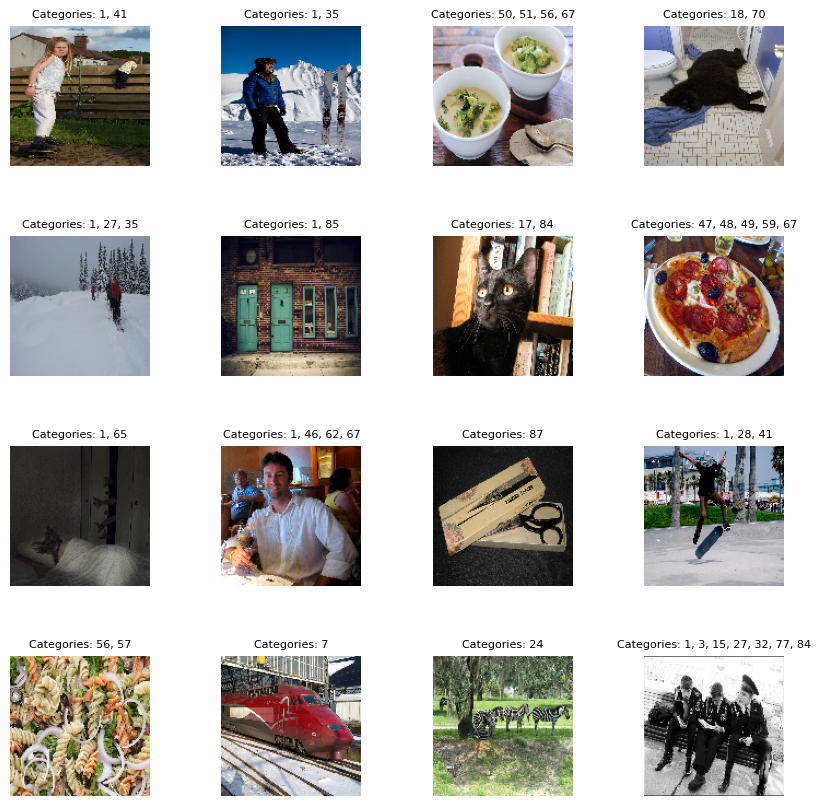

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for img, label in train_loader:
    img = img / 2 + 0.5
    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        npimg = img[i].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        plt.imshow(npimg)
        categories = [str(idx + 1) for idx, value in enumerate(label[i].tolist()) if value == 1]
        plt.title(f'Categories: {", ".join(categories)}', fontsize=8)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    break
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size=3, stride=1, padding=1, dilation=1,
                 deformable_groups=1, bias=False, channelwise=False):
        super(DeformableConv2d, self).__init__()
        assert type(kernel_size) == tuple or type(kernel_size) == int
        self.kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.offset_kernel = self.kernel_size
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation
        deformable_groups = deformable_groups * (in_channels if channelwise else 1)
        self.offset_conv = nn.Conv2d(
            in_channels,
            2 * deformable_groups * self.kernel_size[0] * self.kernel_size[1],
            kernel_size=self.offset_kernel,
            stride=1, padding='same',
            dilation=self.dilation, bias=False
        )

        self.modulator_conv = nn.Conv2d(
            in_channels,
            deformable_groups * self.kernel_size[0] * self.kernel_size[1],
            kernel_size=self.offset_kernel,
            stride=1, padding='same',
            dilation=self.dilation, bias=False
        )

        self.def_channel = deformable_groups * self.kernel_size[0] * self.kernel_size[1]

        self.regular_conv = nn.Conv2d(
            deformable_groups * in_channels,
            out_channels,
            kernel_size=self.kernel_size,
            stride=(self.stride[0] * self.kernel_size[0], self.stride[1] * self.kernel_size[1]),
            padding=self.padding,
            dilation=self.dilation, bias=bias
        )


    def compute_deformed_features(self, x):
        offset = self.offset_conv(x)
        mask = 2 * torch.sigmoid(self.modulator_conv(x))
        N, C, H, W = x.size()
        # Generate grid
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
        grid_y = grid_y.to(device=x.device, dtype=torch.float32)
        grid_x = grid_x.to(device=x.device, dtype=torch.float32)
        grid_y = grid_y.view(1, H, W) + offset[:, :self.def_channel, :, :]
        grid_x = grid_x.view(1, H, W) + offset[:, self.def_channel: , :, :]
        grid_y = 2 * grid_y / (H - 1) - 1
        grid_x = 2 * grid_x / (W - 1) - 1

        # Interpolate features using grid and mask
        grid = torch.stack((grid_x, grid_y), dim=-1)
        features = torch.zeros((N, C, H * self.kernel_size[0], W * self.kernel_size[1]))

        # create bigger feature, offset applied
        for i in range(self.def_channel):
            x0 = i % self.kernel_size[0]
            y0 = int(i / self.kernel_size[0])
            g = grid[:, i, :, :, :]
            # sample
            samples = nn.functional.grid_sample(x, g, mode='bilinear', align_corners=False)
            # apply mask
            samples = samples * mask[:, i:i+1, :, :]
            features[:, :,
                y0:(y0 + H * self.kernel_size[0]):self.kernel_size[0],
                x0:W * self.kernel_size[1]:self.kernel_size[1]
            ] = samples

        features = features.to(device=x.device)

        return features

    def forward(self, x):
        deformed_features = self.compute_deformed_features(x)
        output = self.regular_conv(deformed_features)
        return output

* Deformable and Normal Convolutions test and comparison

## ResNet Block with normal convolution

In [24]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, deformable=False):
        super(ResNetBlock, self).__init__()
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        self.conv1 = conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(out_channels)
        self.BN_res = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = conv(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = nn.BatchNorm2d(out_channels)
        self.BN3 = nn.BatchNorm2d(out_channels)
        # Bottleneck layer
        self.conv_res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        residual = x.clone()
        residual = self.conv_res(residual)
        residual = self.BN_res(residual)
        residual = torch.relu(residual)
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = x + residual
        x = self.conv3(x)
        x = self.BN3(x)
        x = torch.relu(x)
        x = self.pool(x)
        return x
class CocoClassifierDeform(nn.Module):
    def __init__(self, num_classes, in_channels, deformable=False):
        super(CocoClassifierDeform, self).__init__()

        self.block1 = ResNetBlock(in_channels, 32, deformable=deformable)
        self.block2 = ResNetBlock(32, 64, deformable=deformable)
        self.block4 = ResNetBlock(128, 512, deformable=False)  # Normal conv for last layers
        self.block3 = ResNetBlock(64, 128, deformable=False)   # Normal conv for last layers

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.BN = nn.BatchNorm1d(num_classes)
        self.classifier = nn.Sigmoid()

    def conv_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

    def forward(self, x):
        x = self.conv_features(x)
        x = self.gap(x)
        x = torch.squeeze(x, dim=(2, 3))
        x = self.fc(x)
        x = self.BN(x)
        x = self.classifier(x)
        return x


In [34]:
model = CocoClassifierDeform(
    in_channels=3, num_classes=90, deformable=False
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [35]:
if torch.cuda.device_count() > 1:
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    devices = list(range(torch.cuda.device_count()))
    model = nn.DataParallel(model, device_ids=devices)  # Use DataParallel to utilize multiple GPUs
    criterion = criterion.to(devices[0])  # Move criterion to the first GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

Number of GPUs available: 2
Using device: cuda


Validation - epoch 1/10: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Epoch [1/10], Loss: 0.6540, Precision: 0.1336, Recall: 0.2416, F1: 0.1721, Accuracy: 0.9239


Train - epoch 2/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 2/10: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Epoch [2/10], Loss: 0.4529, Precision: 0.4532, Recall: 0.1331, F1: 0.2058, Accuracy: 0.9664


Train - epoch 3/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 3/10: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Epoch [3/10], Loss: 0.3376, Precision: 0.5744, Recall: 0.1423, F1: 0.2281, Accuracy: 0.9685


Train - epoch 4/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 4/10: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch [4/10], Loss: 0.2711, Precision: 0.5527, Recall: 0.1328, F1: 0.2141, Accuracy: 0.9681


Train - epoch 5/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 5/10: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Epoch [5/10], Loss: 0.2280, Precision: 0.5018, Recall: 0.1673, F1: 0.2509, Accuracy: 0.9673


Train - epoch 6/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 6/10: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Epoch [6/10], Loss: 0.2097, Precision: 0.6123, Recall: 0.1338, F1: 0.2196, Accuracy: 0.9689


Train - epoch 7/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 7/10: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Epoch [7/10], Loss: 0.2066, Precision: 0.6126, Recall: 0.1321, F1: 0.2173, Accuracy: 0.9689


Train - epoch 8/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 8/10: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Epoch [8/10], Loss: 0.2036, Precision: 0.6209, Recall: 0.1299, F1: 0.2149, Accuracy: 0.9689


Train - epoch 9/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 9/10: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Epoch [9/10], Loss: 0.2005, Precision: 0.6219, Recall: 0.1377, F1: 0.2255, Accuracy: 0.9690


Train - epoch 10/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 10/10: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Epoch [10/10], Loss: 0.1975, Precision: 0.6227, Recall: 0.1404, F1: 0.2292, Accuracy: 0.9691


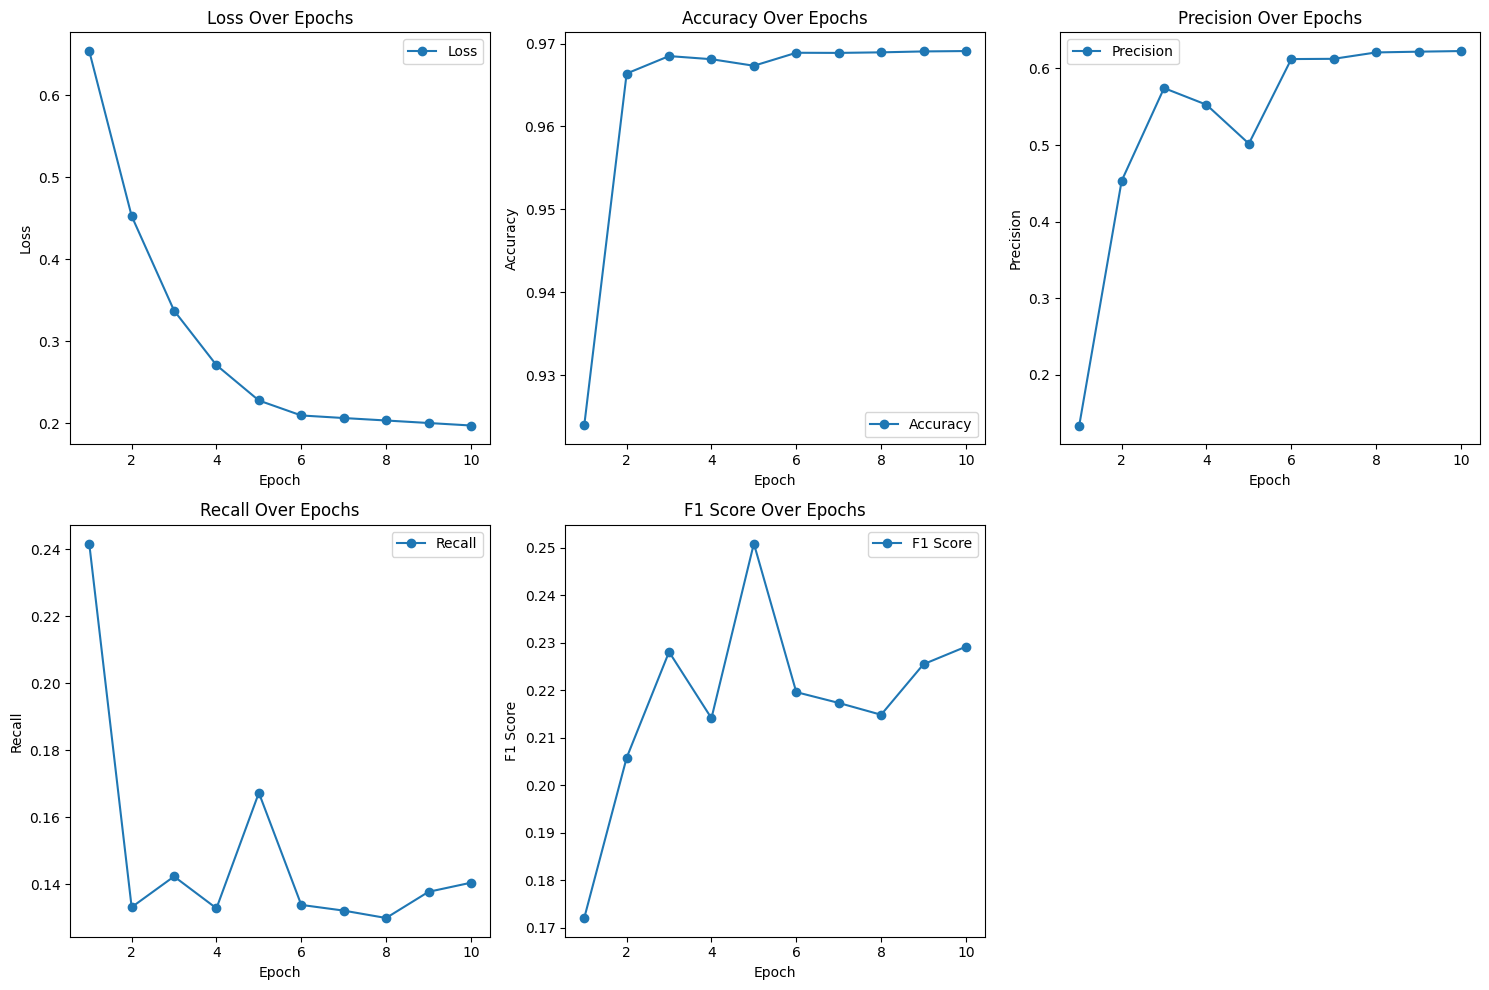

In [36]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision_list_norm = []
recall_list_norm = []
f1_list_norm = []
accuracy_list_norm = []
loss_list_norm = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []
    for inputs, labels in tqdm(train_loader, desc=f'Train - epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_list_norm.append(epoch_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Validation - epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs > 0.5).float()
            all_predicted_labels.extend(predicted.cpu().numpy().flatten())
            all_true_labels.extend(labels.cpu().numpy().flatten())

        # Calculate metrics
        epoch_precision, epoch_recall, epoch_f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')
        precision_list_norm.append(epoch_precision)
        recall_list_norm.append(epoch_recall)
        f1_list_norm.append(epoch_f1)

        # Calculate accuracy
        accuracy = accuracy_score(all_true_labels, all_predicted_labels)
        accuracy_list_norm.append(accuracy)

    scheduler.step()

    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}, Accuracy: {accuracy:.4f}')

# Plotting
epochs = range(1, num_epochs+1)

plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 3, 1)
plt.plot(epochs, loss_list_norm, label='Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 3, 2)
plt.plot(epochs, accuracy_list_norm, label='Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(2, 3, 3)
plt.plot(epochs, precision_list_norm, label='Precision', marker='o')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(2, 3, 4)
plt.plot(epochs, recall_list_norm, label='Recall', marker='o')
plt.title('Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# F1 Score plot
plt.subplot(2, 3, 5)
plt.plot(epochs, f1_list_norm, label='F1 Score', marker='o')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


Validation - epoch 10/10:|
`Loss: 0.1975, Precision: 0.6227, Recall: 0.1404, F1: 0.2292, Accuracy: 0.9691`

In [37]:
model.eval()
all_predicted_labels_test = []
all_true_labels_test = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating on test set'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        all_predicted_labels_test.extend(predicted.cpu().numpy().flatten())
        all_true_labels_test.extend(labels.cpu().numpy().flatten())
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(all_true_labels_test, all_predicted_labels_test, average='binary')
print(f'\n Linear ConvNet model Precision on test dataset: {precision_test:.4f}')
print(f'Linear ConvNet model model Recall on test dataset: {recall_test:.4f}')
print(f'Linear ConvNet model model F1 score on test dataset: {f1_test:.4f}')

Evaluating on test set:   0%|          | 0/79 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluating on test set: 100%|██████████| 79/79 [00:36<00:00,  2.16it/s]



 Linear ConvNet model Precision on test dataset: 0.6261
Linear ConvNet model model Recall on test dataset: 0.1403
Linear ConvNet model model F1 score on test dataset: 0.2293


Evaluating on test set:

Linear ConvNet model Precision on test dataset: 0.6261
Linear ConvNet model model Recall on test dataset: 0.1403
Linear ConvNet model model F1 score on test dataset: 0.2293

## Deformable block configuration

In [48]:
del deformable_model

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Multi-GPU available: {torch.cuda.device_count()} GPUs")
    device = torch.device("cuda:0")  # Choose the first GPU
else:
    print("Multi-GPU not available. Using a single GPU or CPU.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deformable_model = CocoClassifierDeform(
    in_channels=3, num_classes=90, deformable=True
).to(device)
deformable_model = nn.DataParallel(deformable_model)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(deformable_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Multi-GPU available: 2 GPUs


Validation - epoch 1/10: 100%|██████████| 32/32 [01:26<00:00,  2.69s/it]


Epoch [1/10], Loss: 0.6522, Precision: 0.0558, Recall: 0.3362, F1: 0.0957, Accuracy: 0.7922


Train - epoch 2/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 2/10: 100%|██████████| 32/32 [01:21<00:00,  2.55s/it]


Epoch [2/10], Loss: 0.4522, Precision: 0.4315, Recall: 0.1396, F1: 0.2109, Accuracy: 0.9658


Train - epoch 3/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 3/10: 100%|██████████| 32/32 [01:23<00:00,  2.61s/it]


Epoch [3/10], Loss: 0.3380, Precision: 0.5567, Recall: 0.1467, F1: 0.2322, Accuracy: 0.9683


Train - epoch 4/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 4/10: 100%|██████████| 32/32 [01:24<00:00,  2.63s/it]


Epoch [4/10], Loss: 0.2716, Precision: 0.5652, Recall: 0.1406, F1: 0.2252, Accuracy: 0.9683


Train - epoch 5/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 5/10: 100%|██████████| 32/32 [01:24<00:00,  2.63s/it]


Epoch [5/10], Loss: 0.2284, Precision: 0.5831, Recall: 0.1347, F1: 0.2188, Accuracy: 0.9685


Train - epoch 6/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 6/10: 100%|██████████| 32/32 [01:22<00:00,  2.57s/it]


Epoch [6/10], Loss: 0.2099, Precision: 0.5775, Recall: 0.1411, F1: 0.2268, Accuracy: 0.9685


Train - epoch 7/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 7/10: 100%|██████████| 32/32 [01:23<00:00,  2.61s/it]


Epoch [7/10], Loss: 0.2070, Precision: 0.5889, Recall: 0.1350, F1: 0.2196, Accuracy: 0.9686


Train - epoch 8/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 8/10: 100%|██████████| 32/32 [01:27<00:00,  2.72s/it]


Epoch [8/10], Loss: 0.2039, Precision: 0.5889, Recall: 0.1384, F1: 0.2241, Accuracy: 0.9687


Train - epoch 9/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 9/10: 100%|██████████| 32/32 [01:24<00:00,  2.64s/it]


Epoch [9/10], Loss: 0.2009, Precision: 0.5907, Recall: 0.1399, F1: 0.2262, Accuracy: 0.9687


Train - epoch 10/10:   0%|          | 0/47 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Validation - epoch 10/10: 100%|██████████| 32/32 [01:25<00:00,  2.69s/it]


Epoch [10/10], Loss: 0.1979, Precision: 0.5961, Recall: 0.1338, F1: 0.2186, Accuracy: 0.9687


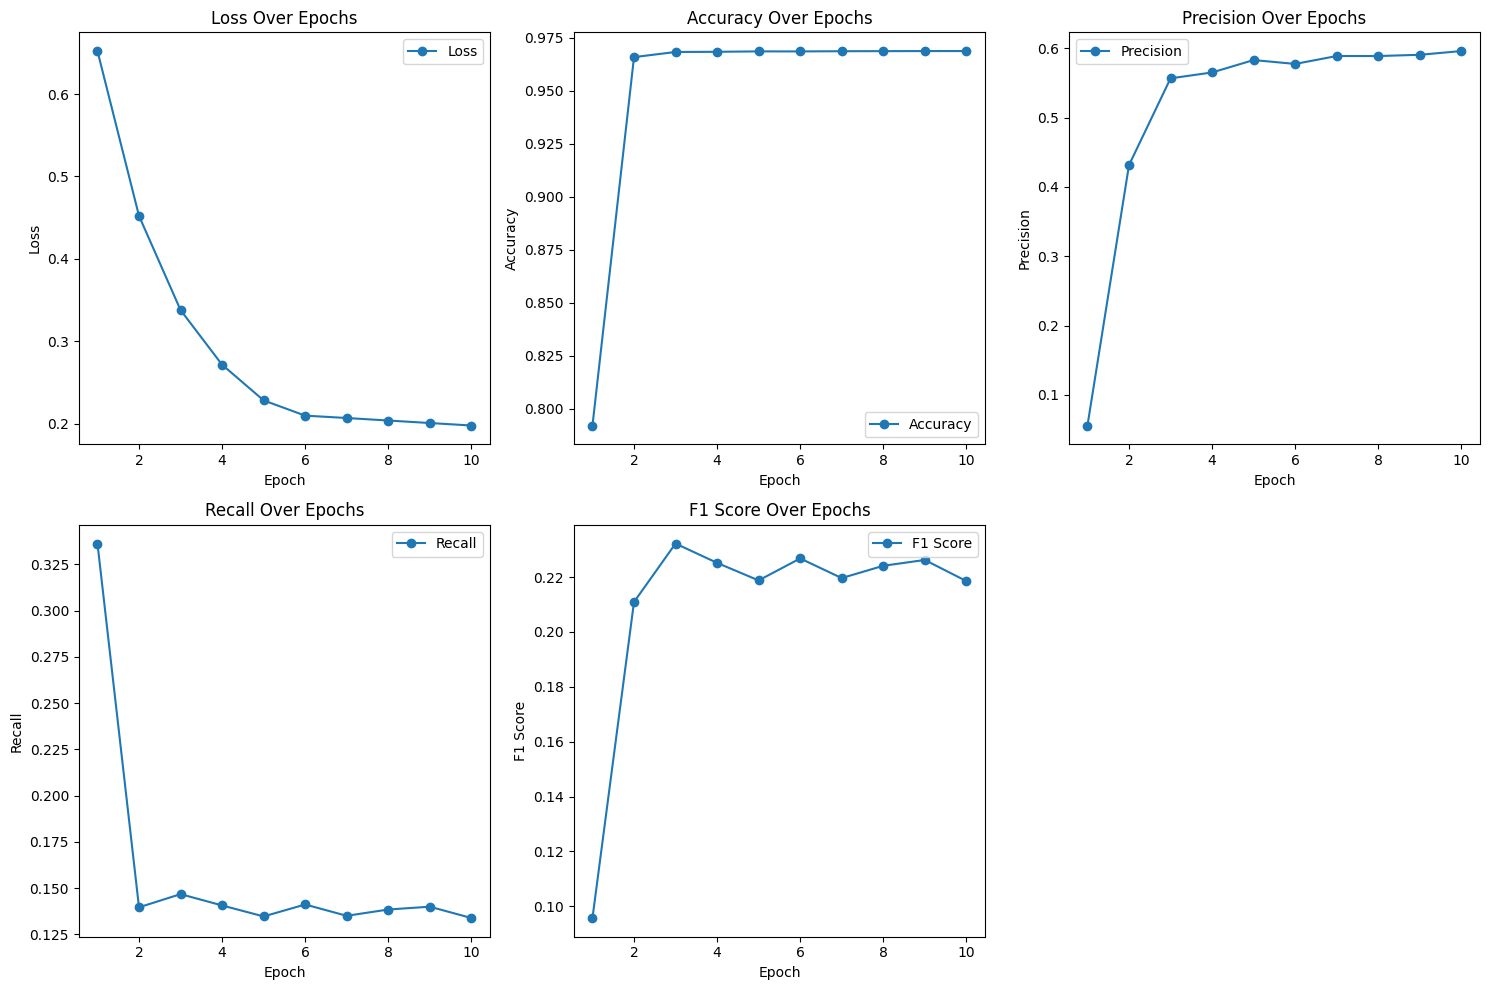

In [51]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision_list_norm = []
recall_list_norm = []
f1_list_norm = []
accuracy_list_norm = []
loss_list_norm = []

num_epochs = 10
deformable_model.train()  # Move model training outside the loop if applicable
for epoch in range(num_epochs):
    
    deformable_model.train()  # Move model training outside the loop if applicable
    running_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []
    for inputs, labels in tqdm(train_loader, desc=f'Train - epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = deformable_model(inputs)  # Use 'deformable_model' here
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_list_norm.append(epoch_loss)

    # Evaluation on validation set
    deformable_model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Validation - epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = deformable_model(inputs)  # Use 'deformable_model' here
            loss = criterion(outputs, labels)
            predicted = (outputs > 0.5).float()
            all_predicted_labels.extend(predicted.cpu().numpy().flatten())
            all_true_labels.extend(labels.cpu().numpy().flatten())

        # Calculate metrics
        epoch_precision, epoch_recall, epoch_f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')
        precision_list_norm.append(epoch_precision)
        recall_list_norm.append(epoch_recall)
        f1_list_norm.append(epoch_f1)

        # Calculate accuracy
        accuracy = accuracy_score(all_true_labels, all_predicted_labels)
        accuracy_list_norm.append(accuracy)

    scheduler.step()

    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}, Accuracy: {accuracy:.4f}')

# Plotting
epochs = range(1, num_epochs+1)

plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 3, 1)
plt.plot(epochs, loss_list_norm, label='Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(2, 3, 2)
plt.plot(epochs, accuracy_list_norm, label='Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Precision plot
plt.subplot(2, 3, 3)
plt.plot(epochs, precision_list_norm, label='Precision', marker='o')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(2, 3, 4)
plt.plot(epochs, recall_list_norm, label='Recall', marker='o')
plt.title('Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# F1 Score plot
plt.subplot(2, 3, 5)
plt.plot(epochs, f1_list_norm, label='F1 Score', marker='o')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
